In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from iminuit.cost import LeastSquares

from FitAPI import Model, Fitter, ResonancePeakSearcher
import models as md

In [2]:
def read_peaks_data(filename):
    data_dict = {}       # stores the dataset values as NumPy arrays
    metadata_dict = {}   # stores the metadata (attributes) for each dataset
    def process_dataset(name, obj):
        if isinstance(obj, h5py.Dataset):
            bias_key = float(obj.attrs.get("bias_current (uA)"))
            if bias_key is not None:
                data_dict[bias_key] = obj[()]
                metadata_dict[bias_key] = {k: v for k, v in obj.attrs.items()}
            else:
                print(f"Warning: Dataset '{name}' missing 'bias_current (uA)' attribute.")

    with h5py.File(filename, 'r') as f:
        f.visititems(process_dataset)

    return data_dict, metadata_dict

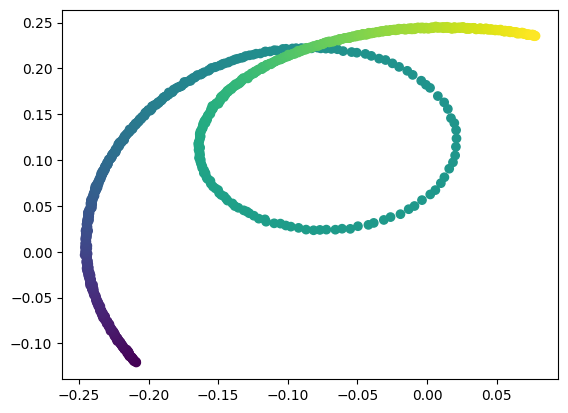

In [3]:
data_dict, metadata_dict = read_peaks_data('../Experiments/TRswipe/run-6/data/peaks_data.h5')

# Example plot of one peak
bias_current = 0.5
peak_data = data_dict[bias_current]
# transpose the data to match the expected shape (rows, columns)
# peak_data = peak_data.T
f = peak_data[0]
I = peak_data[1]
Q = peak_data[2]

plt.scatter(I, Q, c=f, cmap='viridis')

In [4]:
amp = np.sqrt(I**2 + Q**2)
amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
data_test = np.array([f, amp_dBm]).T
data_test

array([[6.22400000e+09, 4.76472511e+01],
       [6.22401001e+09, 4.76404521e+01],
       [6.22402002e+09, 4.76752595e+01],
       ...,
       [6.23397998e+09, 4.78968285e+01],
       [6.23398999e+09, 4.78926573e+01],
       [6.23400000e+09, 4.78729703e+01]], shape=(1000, 2))

In [5]:
# try to fit
model = md.resonance_model
fitter = Fitter(model_function=md.resonance_model, 
                    param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"], 
                    data=data_test, 
                    loss_function=LeastSquares
                )

searcher = ResonancePeakSearcher()
result = fitter.fit_magicus(searcher=searcher)

In [6]:
fav_guess = {
    "fmin": 6229355355,
    "f0": 6229355355, #0.1,
    "phi": -0.2369, # 2.1,
    "Qc": 29208,
    "A": 0.0, #1.0,
    "B": 2.8643e-8 ,#1e-9,
    "C": 8.0398e-15,#1e-18,
    "D": -3.5988e-20, # 1e-27
    "K": 0.0, #1e-3,
    "Qt": 29208
    }

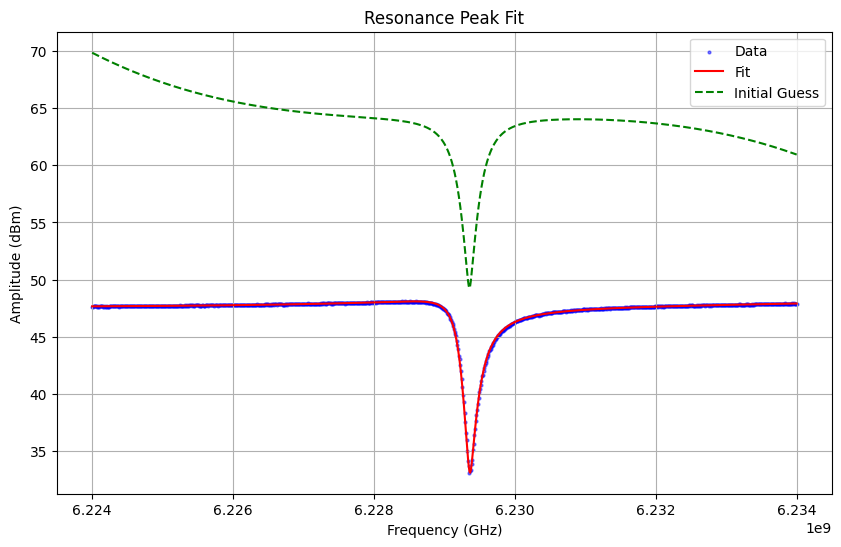

In [7]:
fitted_params = result.values.to_dict()
# Add fmin to the fitted parameters
fitted_params['fmin'] = searcher.params['fmin']
# Plot the fit result
plt.figure(figsize=(10, 6))
plt.scatter(data_test[:, 0], data_test[:, 1], label='Data', color='blue', alpha=0.5, s=4)
plt.plot(data_test[:, 0], model(data_test[:, 0], *fitted_params.values()), label='Fit', color='red')
#plot also the curve with the initial guess
plt.plot(data_test[:, 0], model(data_test[:, 0], *searcher.params.values()), label='Initial Guess', color='green', linestyle='--')
# plto the curve with fav_guess
# plt.plot(data_test[:, 0], model(data_test[:, 0], *fav_guess.values()), label='Fav Guess', color='orange', linestyle='--')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dBm)')
plt.title('Resonance Peak Fit')
plt.legend()
plt.grid()
plt.show()

## Fit first peak

Fit for bias current 3.5 failed (invalid result)


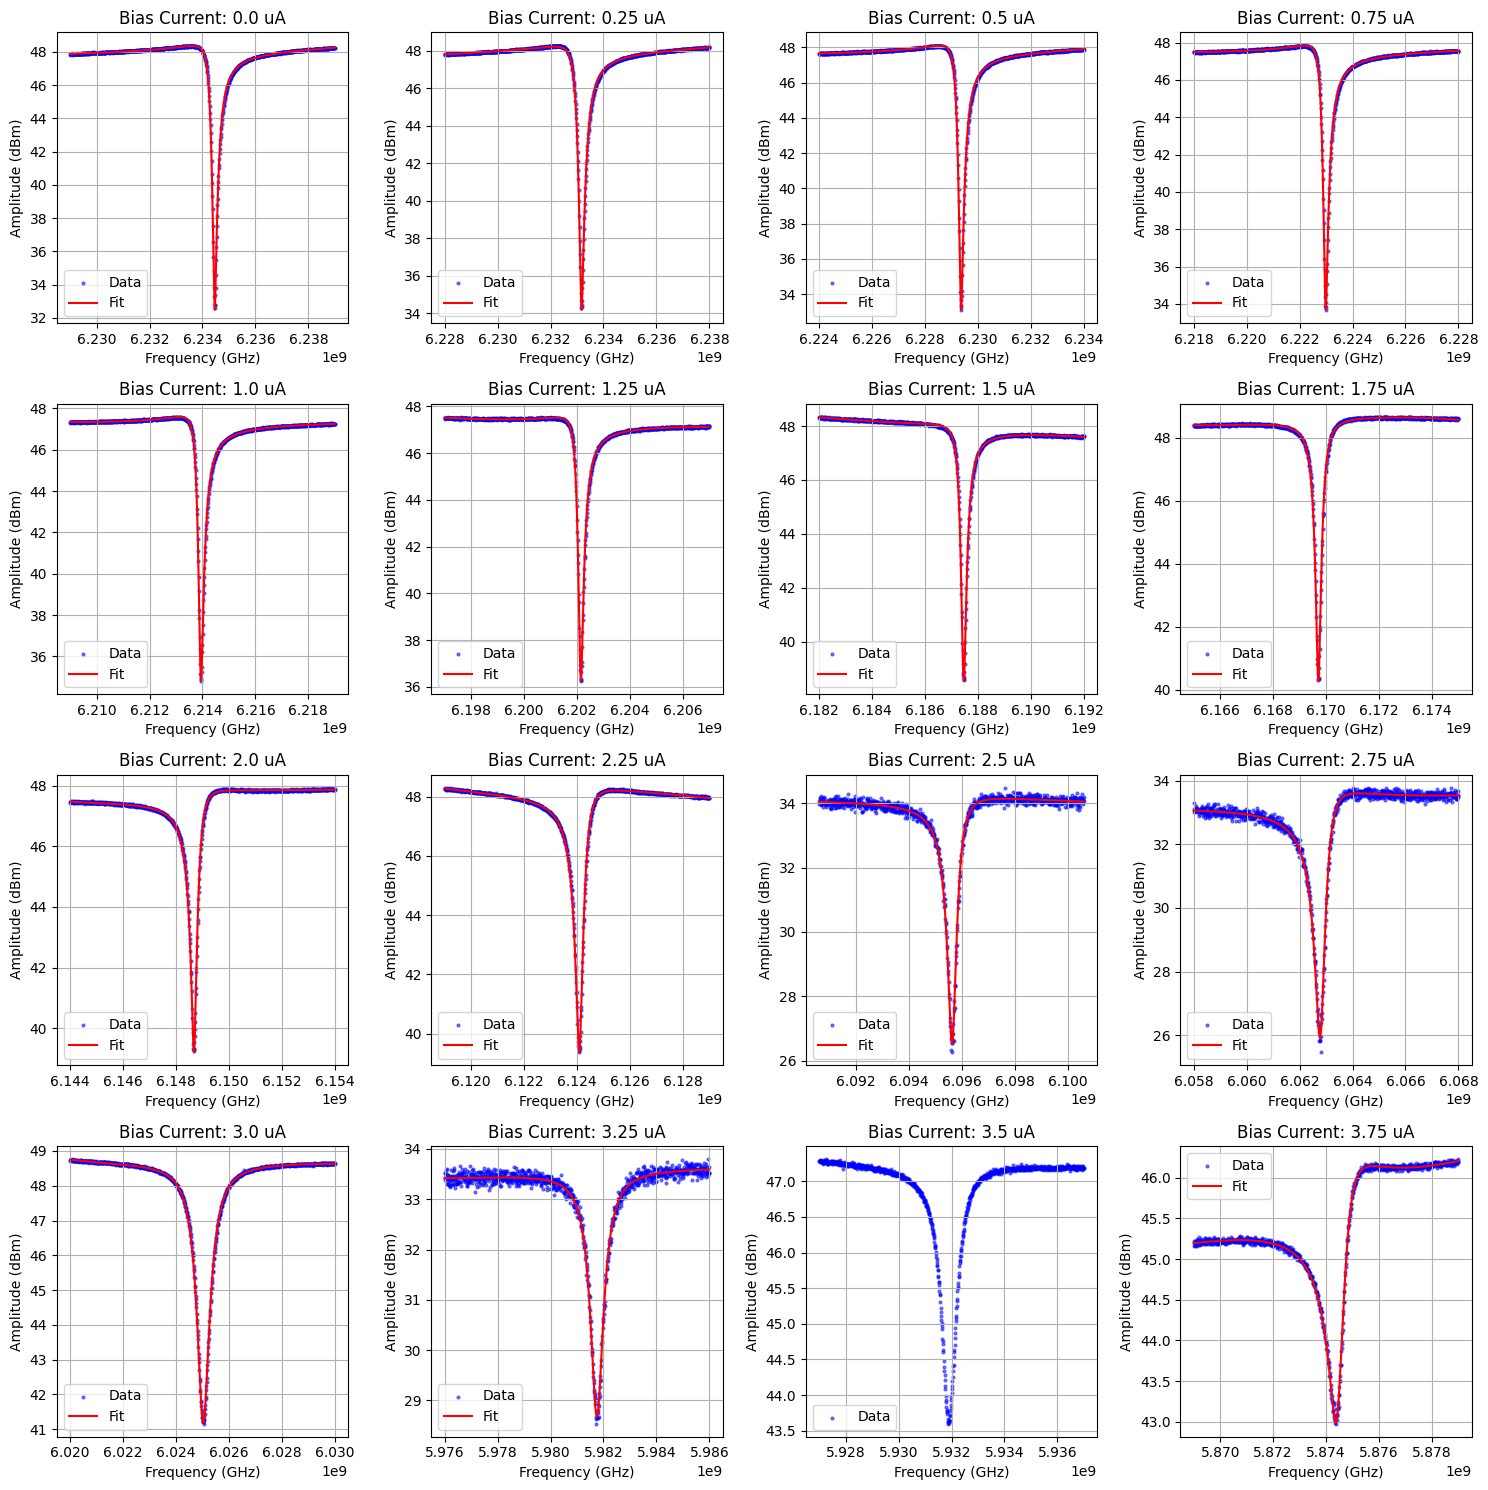

In [3]:
peak1_data, peak1_metadata = read_peaks_data('../Experiments/TRswipe/run-6/data/peaks_data.h5')

resonance_frequneces = []
bias_currents = []

nof_peaks = len(peak1_data)
fig, ax = plt.subplots(int(np.sqrt(nof_peaks)), int(np.sqrt(nof_peaks)), figsize=(15, 15))
row_iter = 0
col_iter = 0

for bias_current, peak_data in peak1_data.items():
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]

    amp = np.sqrt(I**2 + Q**2)
    amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
    peak_data = np.array([f, amp_dBm]).T

    # try to fit
    model = md.resonance_model
    fitter = Fitter(model_function=md.resonance_model, 
                        param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"], 
                        data=peak_data, 
                        loss_function=LeastSquares
                    )

    searcher = ResonancePeakSearcher()
    result = fitter.fit_magicus(searcher=searcher)

    # Check if the fit was successful
    if result.valid:
        # p-value test
        p_value = fitter.p_value(result)
        if p_value < 0.05:
            print(f"Fit for bias current {bias_current} failed (p-value: {p_value})")
            # For now we take the fmin as the resonance frequency
            resonance_frequency = searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            bias_currents.append(bias_current)
            continue
        else:
            # Extract the resonance frequency from the fitted parameters
            resonance_frequency = result.values['f0'] + searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            bias_currents.append(bias_current)
            # Plot the fit result
            fitted_params = result.values.to_dict()
            fitted_params['fmin'] = searcher.params['fmin']
            ax[row_iter, col_iter].scatter(peak_data[:, 0], peak_data[:, 1], label='Data', color='blue', alpha=0.5, s=4)
            ax[row_iter, col_iter].plot(peak_data[:, 0], model(peak_data[:, 0], *fitted_params.values()), label='Fit', color='red')
            # add labels, title and legend
            ax[row_iter, col_iter].set_xlabel('Frequency (GHz)')
            ax[row_iter, col_iter].set_ylabel('Amplitude (dBm)')
            ax[row_iter, col_iter].set_title(f'Bias Current: {bias_current} uA')
            ax[row_iter, col_iter].legend()
            ax[row_iter, col_iter].grid()
    else:
        print(f"Fit for bias current {bias_current} failed (invalid result)")
        # For now we take the fmin as the resonance frequency
        resonance_frequency = searcher.params['fmin']
        resonance_frequneces.append(resonance_frequency)
        bias_currents.append(bias_current)
        # Plot anyway the data
        ax[row_iter, col_iter].scatter(peak_data[:, 0], peak_data[:, 1], label='Data', color='blue', alpha=0.5, s=4)
        # add labels, title and legend
        ax[row_iter, col_iter].set_xlabel('Frequency (GHz)')
        ax[row_iter, col_iter].set_ylabel('Amplitude (dBm)')
        ax[row_iter, col_iter].set_title(f'Bias Current: {bias_current} uA')
        ax[row_iter, col_iter].legend()
        ax[row_iter, col_iter].grid()

    # update iterators
    col_iter += 1
    if col_iter >= int(np.sqrt(nof_peaks)):
        col_iter = 0
        row_iter += 1

# adjust the layout
plt.tight_layout()
plt.show()

In [4]:
# Renormalize the resonance frequencies with respect to the frequency at 0 bias current
resonance_frequneces_normalized = np.array(resonance_frequneces)
bias_currents = np.array(bias_currents)
resonance_frequneces_normalized -= resonance_frequneces[0]
resonance_frequneces_normalized /= resonance_frequneces[0] if resonance_frequneces[0] != 0 else 1

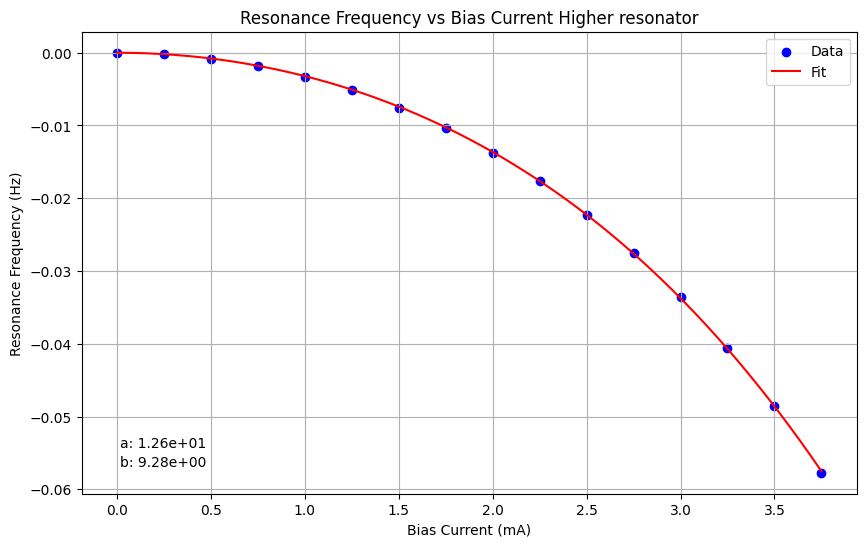

In [5]:
# Fit resonance frequency vs bias current
model = md.parametric_resonator_peak_vs_bias_current
fitter = Fitter(model_function=model, 
                    param_names=["a", "b"], 
                    data=np.array([bias_currents, resonance_frequneces_normalized]).T, 
                    loss_function=LeastSquares,
                    params_initial_guess={"a": 1, "b": 1}, # initial guess for the parameters
                )



result = fitter.fit()
fitted_params = result.values.to_dict()

test_params = {
    "a": -1e4,
    "b": -1e3,
}

# Plot the resonance frequencies vs bias currents
plt.figure(figsize=(10, 6))
plt.scatter(bias_currents, resonance_frequneces_normalized, color='blue', label='Data')
linspace = np.linspace(min(bias_currents), max(bias_currents), 200)
plt.plot(linspace, model(linspace, *fitted_params.values()), label='Fit', color='red')
# plt.plot(bias_currents, model(bias_currents, *test_params.values()), label='Test', color='green', linestyle='--')
# Add a and b to the plot
plt.text(0.05, 0.1, f'a: {fitted_params["a"]:.2e}', transform=plt.gca().transAxes)
plt.text(0.05, 0.06, f'b: {fitted_params["b"]:.2e}', transform=plt.gca().transAxes)

plt.xlabel('Bias Current (mA)')
plt.ylabel('Resonance Frequency (Hz)')
plt.title('Resonance Frequency vs Bias Current Higher resonator')
plt.legend()
plt.grid()
plt.show()

## Fit second peak

Fit for bias current 0.0 failed (invalid result)
Fit for bias current 1.85 failed (invalid result)


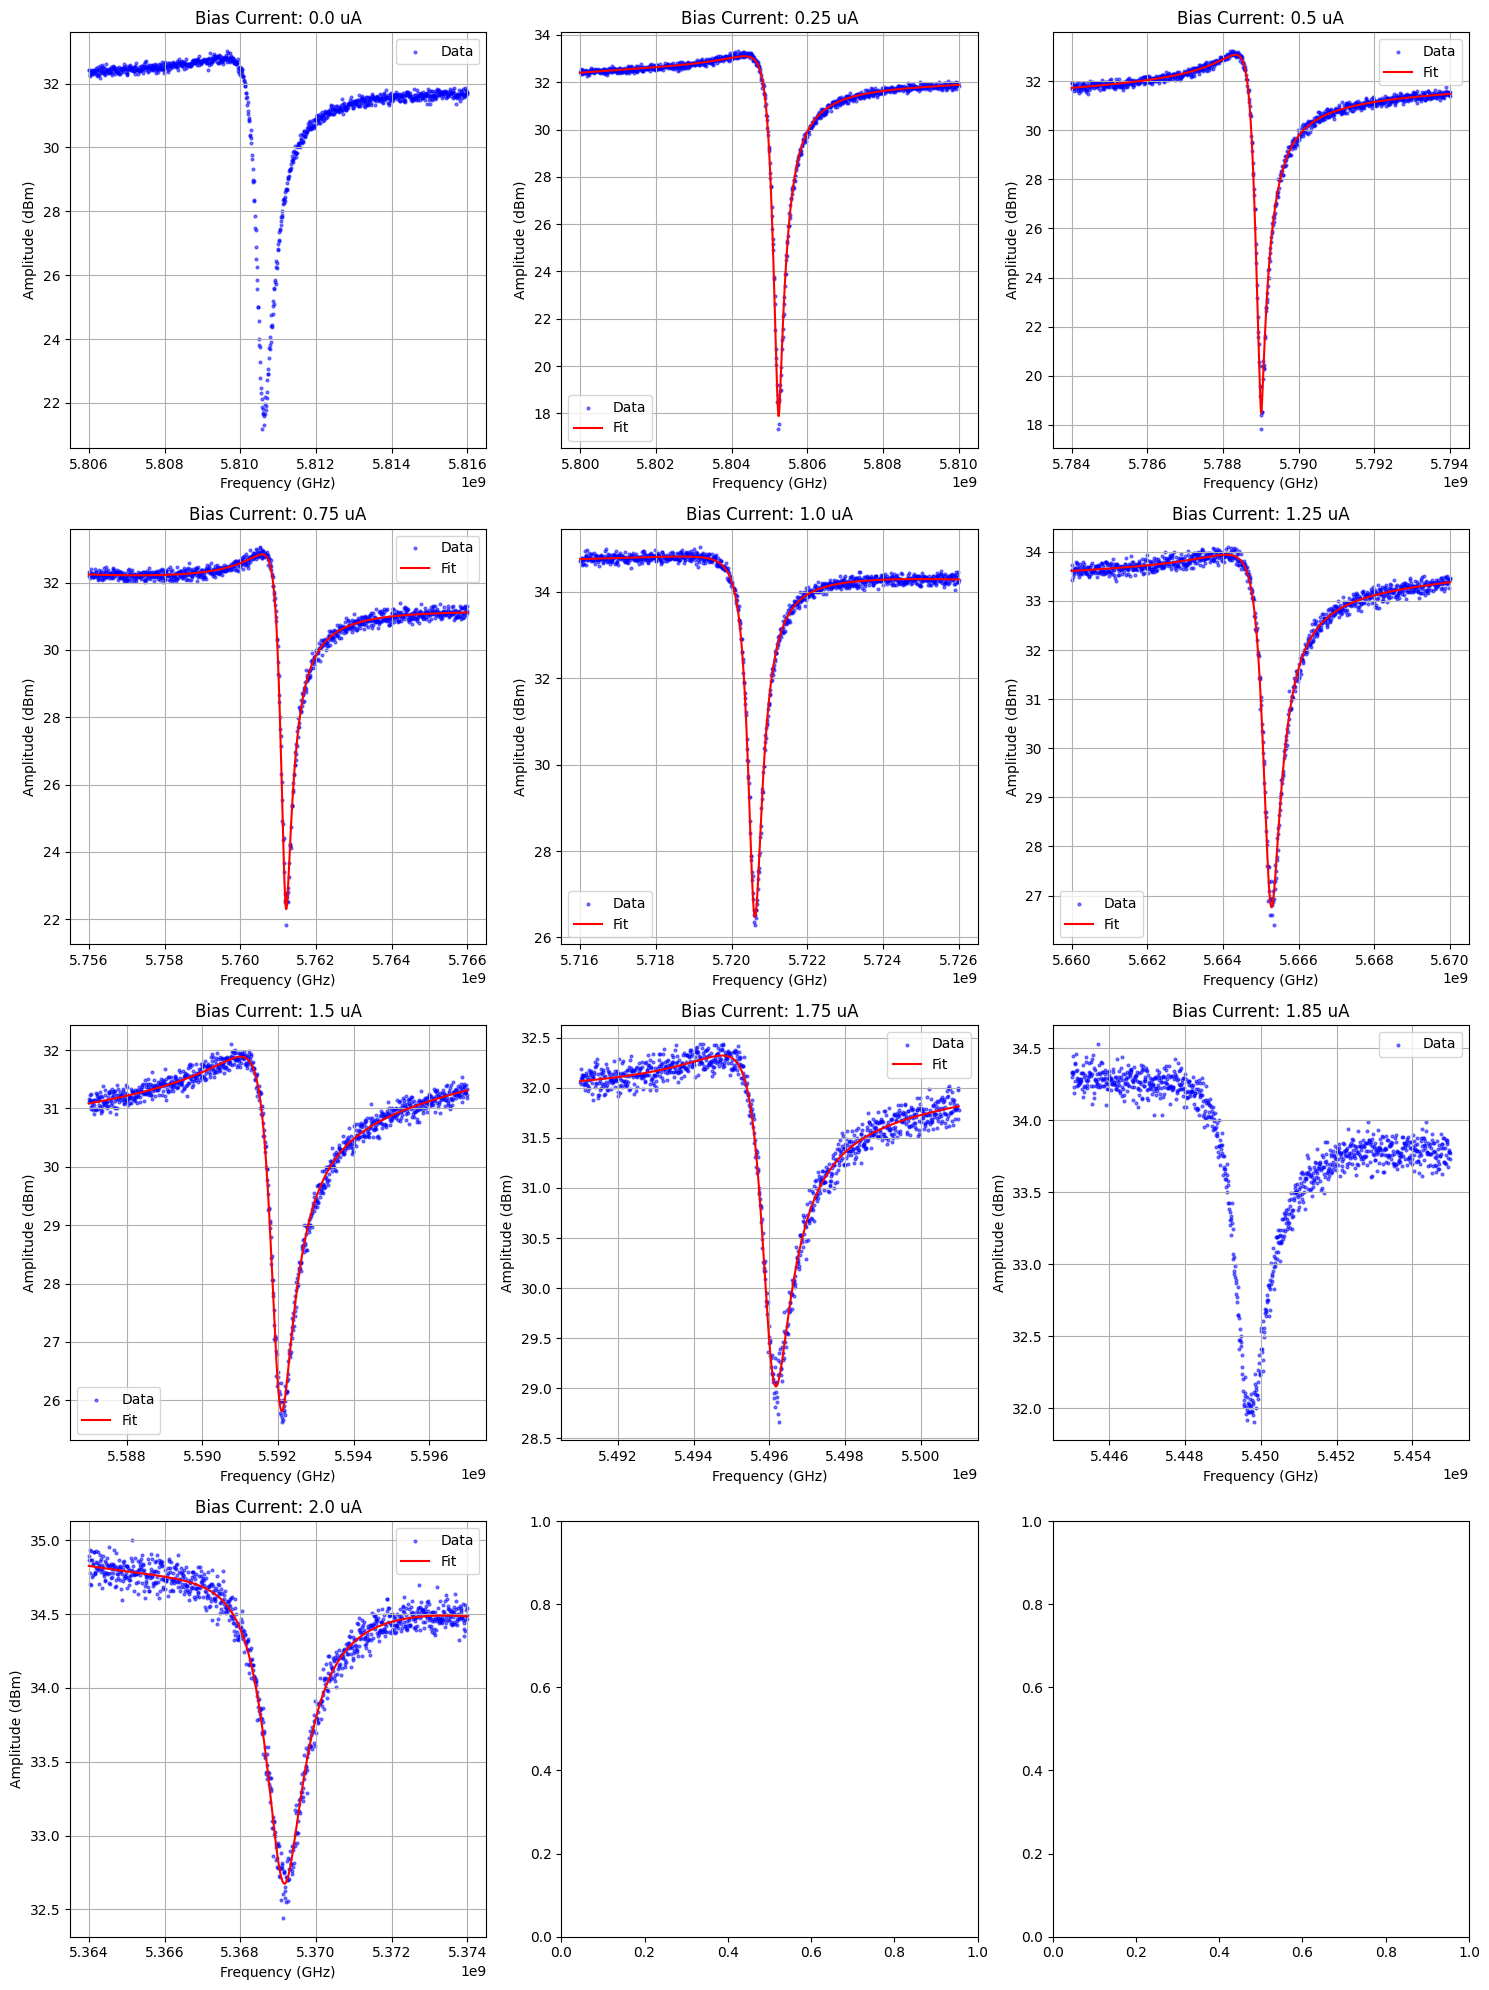

In [6]:
peak2_data, peak2_metadata = read_peaks_data('../Experiments/TRswipe/run-7/data/peaks_data.h5')

resonance_frequneces_peak2 = []
bias_currents_peak2 = []

nof_peaks_peak2 = len(peak2_data)
nrow, ncols = int(np.ceil(np.sqrt(nof_peaks_peak2))), int(np.sqrt(nof_peaks_peak2))
factor = nrow / ncols
fig, ax = plt.subplots(nrow, ncols, figsize=(15, 15*factor))
row_iter = 0
col_iter = 0

for bias_current, peak_data in peak2_data.items():
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]

    amp = np.sqrt(I**2 + Q**2)
    amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
    peak_data = np.array([f, amp_dBm]).T

    # try to fit
    model = md.resonance_model
    fitter = Fitter(model_function=md.resonance_model, 
                        param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"], 
                        data=peak_data, 
                        loss_function=LeastSquares
                    )

    searcher = ResonancePeakSearcher()
    result = fitter.fit_magicus(searcher=searcher)

    # Check if the fit was successful
    if result.valid:
        # p-value test
        p_value = fitter.p_value(result)
        if p_value < 0.05:
            print(f"Fit for bias current {bias_current} failed (p-value: {p_value})")
            # For now we take the fmin value as resonance frequency
            resonance_frequency = searcher.params['fmin']
            resonance_frequneces_peak2.append(resonance_frequency)
            bias_currents_peak2.append(bias_current)
            continue
        else:
            # Extract the resonance frequency from the fitted parameters
            resonance_frequency = result.values['f0'] + searcher.params['fmin']
            resonance_frequneces_peak2.append(resonance_frequency)
            bias_currents_peak2.append(bias_current)
            # Plot the fit result
            fitted_params = result.values.to_dict()
            fitted_params['fmin'] = searcher.params['fmin']
            ax[row_iter, col_iter].scatter(peak_data[:, 0], peak_data[:, 1], label='Data', color='blue', alpha=0.5, s=4)
            ax[row_iter, col_iter].plot(peak_data[:, 0], model(peak_data[:, 0], *fitted_params.values()), label='Fit', color='red')
            # add labels, title and legend
            ax[row_iter, col_iter].set_xlabel('Frequency (GHz)')
            ax[row_iter, col_iter].set_ylabel('Amplitude (dBm)')
            ax[row_iter, col_iter].set_title(f'Bias Current: {bias_current} uA')
            ax[row_iter, col_iter].legend()
            ax[row_iter, col_iter].grid()
    else:
        print(f"Fit for bias current {bias_current} failed (invalid result)")
        # For now we take the fmin value as resonance frequency
        resonance_frequency = searcher.params['fmin']
        resonance_frequneces_peak2.append(resonance_frequency)
        bias_currents_peak2.append(bias_current)
        # Plot anyway the data
        ax[row_iter, col_iter].scatter(peak_data[:, 0], peak_data[:, 1], label='Data', color='blue', alpha=0.5, s=4)
        # add labels, title and legend
        ax[row_iter, col_iter].set_xlabel('Frequency (GHz)')
        ax[row_iter, col_iter].set_ylabel('Amplitude (dBm)')
        ax[row_iter, col_iter].set_title(f'Bias Current: {bias_current} uA')
        ax[row_iter, col_iter].legend()
        ax[row_iter, col_iter].grid()

    # update iterators
    col_iter += 1
    if col_iter >= int(np.sqrt(nof_peaks_peak2)):
        col_iter = 0
        row_iter += 1

# adjust the layout
plt.tight_layout()
plt.show()

In [8]:
# Renormalize the resonance frequencies with respect to the frequency at 0 bias current
resonance_frequneces_peak2_normalized = np.array(resonance_frequneces_peak2)
bias_currents_peak2 = np.array(bias_currents_peak2)
resonance_frequneces_peak2_normalized -= resonance_frequneces_peak2[0]
resonance_frequneces_peak2_normalized /= resonance_frequneces_peak2[0] if resonance_frequneces_peak2[0] != 0 else 1

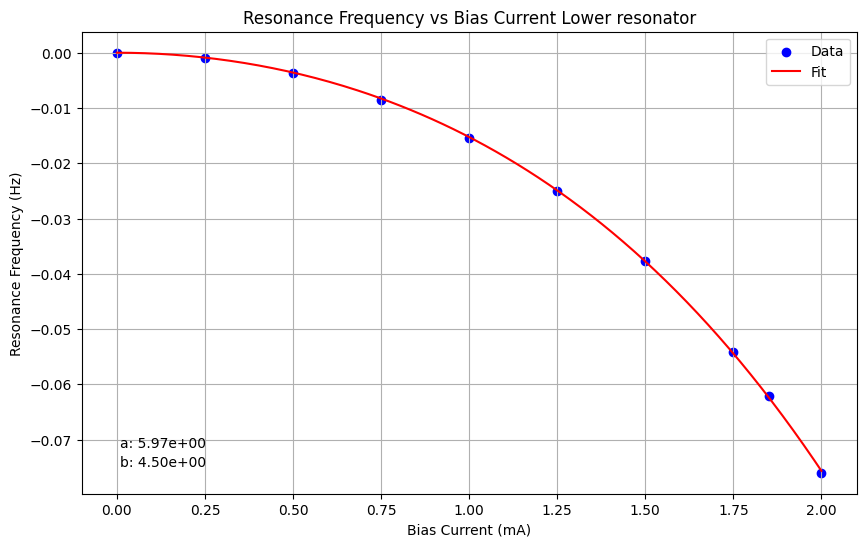

In [9]:
# Fit resonance frequency vs bias current
model = md.parametric_resonator_peak_vs_bias_current
fitter = Fitter(model_function=model, 
                    param_names=["a", "b"], 
                    data=np.array([bias_currents_peak2, resonance_frequneces_peak2_normalized]).T, 
                    loss_function=LeastSquares,
                    params_initial_guess={"a": 1, "b": 1}, # initial guess for the parameters
                )

result = fitter.fit()
fitted_params = result.values.to_dict()

test_params = {
    "a": -1e4,
    "b": -1e3,
}

# Plot the resonance frequencies vs bias currents
plt.figure(figsize=(10, 6))
plt.scatter(bias_currents_peak2, resonance_frequneces_peak2_normalized, color='blue', label='Data')
linspace = np.linspace(bias_currents_peak2.min(), bias_currents_peak2.max(), 200)
plt.plot(linspace, model(linspace, *fitted_params.values()), label='Fit', color='red')
# plt.plot(bias_currents_peak2, model(bias_currents_peak2, *test_params.values()), label='Test', color='green', linestyle='--')
# Add a and b to the plot
plt.text(0.05, 0.1, f'a: {fitted_params["a"]:.2e}', transform=plt.gca().transAxes)
plt.text(0.05, 0.06, f'b: {fitted_params["b"]:.2e}', transform=plt.gca().transAxes)
plt.xlabel('Bias Current (mA)')
plt.ylabel('Resonance Frequency (Hz)')
plt.title('Resonance Frequency vs Bias Current Lower resonator')
plt.legend()
plt.grid()
plt.show()